# Feature Extraction Using Granger Causality Algorithm

## 1. Import Libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
print("✓ Libraries imported!")

✓ Libraries imported!


## 2. Load and Prepare Data

In [50]:
# Load dataset
df = pd.read_csv('Supermart_Cleaned.csv')
df['Order Date'] = pd.to_datetime(df['Order Date'])
df = df.sort_values('Order Date')

# Aggregate by date
daily_data = df.groupby('Order Date').agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean',
    'Order ID': 'count'
}).reset_index()

daily_data.rename(columns={'Order ID': 'Order_Count'}, inplace=True)
daily_data.set_index('Order Date', inplace=True)

# Fill missing dates
daily_data = daily_data.resample('D').asfreq().fillna(method='ffill').interpolate()

# Create moving averages
daily_data['Sales_MA7'] = daily_data['Sales'].rolling(7).mean()
daily_data['Profit_MA7'] = daily_data['Profit'].rolling(7).mean()
daily_data['Discount_MA7'] = daily_data['Discount'].rolling(7).mean()

# Make stationary by differencing
daily_diff = daily_data.diff().dropna()

print(f"Data prepared: {daily_diff.shape}")
daily_diff.head()

Data prepared: (1432, 7)


,Sales,Profit,Discount,Order_Count,Sales_MA7,Profit_MA7,Discount_MA7
Order Date,,,,,,,
2015-01-10,-0.7225,-0.7816,0.3200,0.0000,0.0737,-0.0122,0.0171
2015-01-11,0.0615,0.5310,-0.6000,-1.0000,-0.0336,0.0255,-0.0610
2015-01-12,0.0000,0.0000,0.0000,0.0000,0.0815,0.0937,-0.1200
2015-01-13,0.0000,0.0000,0.0000,0.0000,-0.7202,-0.3057,-0.0613
2015-01-14,0.0000,0.0000,0.0000,0.0000,-0.0498,0.0571,0.0171


## 3. Granger Causality Test

In [51]:
def test_granger_causality(data, target, feature, max_lag=10):
    """Test if feature Granger-causes target"""
    try:
        test_data = data[[target, feature]].dropna()
        gc_result = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)
        
        p_values = [gc_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
        min_p = min(p_values)
        best_lag = p_values.index(min_p) + 1
        
        return {
            'Feature': feature,
            'P_Value': min_p,
            'Best_Lag': best_lag,
            'Selected': 'Yes' if min_p < 0.05 else 'No'
        }
    except:
        return None

# Run tests
target = 'Sales'
features = ['Profit', 'Discount', 'Order_Count', 'Sales_MA7', 'Profit_MA7', 'Discount_MA7']

results = []
for feature in features:
    result = test_granger_causality(daily_diff, target, feature)
    if result:
        results.append(result)

print(f"✓ Tested {len(results)} features")

✓ Tested 6 features


## 4. Results Table

In [52]:
# Create results table
results_df = pd.DataFrame(results).sort_values('P_Value')

print("\n" + "="*60)
print("GRANGER CAUSALITY TEST RESULTS")
print("="*60)
print(results_df.to_string(index=False))

selected = results_df[results_df['Selected'] == 'Yes']
print(f"\n✓ Selected Features: {len(selected)} out of {len(results_df)}")

results_df


GRANGER CAUSALITY TEST RESULTS
     Feature  P_Value  Best_Lag Selected
   Sales_MA7   0.0000         1      Yes
  Profit_MA7   0.0000         1      Yes
 Order_Count   0.0039         1      Yes
      Profit   0.0099         1      Yes
Discount_MA7   0.0268        10      Yes
    Discount   0.2476         6       No

✓ Selected Features: 5 out of 6


,Feature,P_Value,Best_Lag,Selected
3,Sales_MA7,0.0000,1,Yes
4,Profit_MA7,0.0000,1,Yes
2,Order_Count,0.0039,1,Yes
0,Profit,0.0099,1,Yes
5,Discount_MA7,0.0268,10,Yes
1,Discount,0.2476,6,No


## 5. Visualization - P-Values

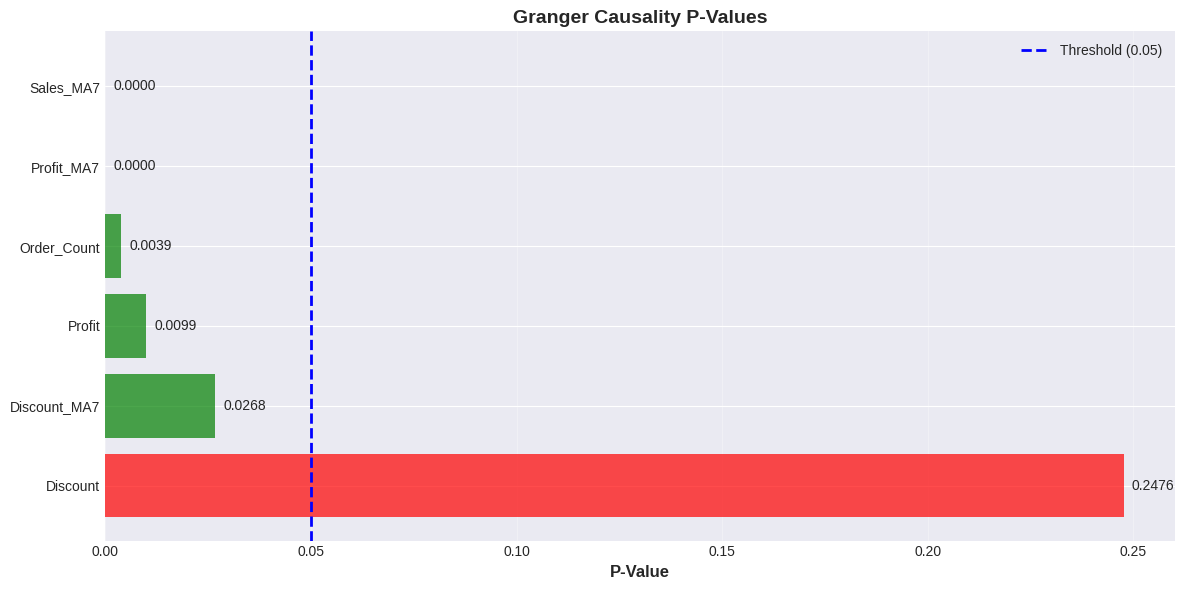

Green = Selected | Red = Not Selected


In [53]:
# P-Value bar chart
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green' if x == 'Yes' else 'red' for x in results_df['Selected']]
ax.barh(results_df['Feature'], results_df['P_Value'], color=colors, alpha=0.7)
ax.axvline(0.05, color='blue', linestyle='--', linewidth=2, label='Threshold (0.05)')

ax.set_xlabel('P-Value', fontsize=12, fontweight='bold')
ax.set_title('Granger Causality P-Values', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

for i, row in enumerate(results_df.itertuples()):
    ax.text(row.P_Value + 0.002, i, f"{row.P_Value:.4f}", va='center')

plt.tight_layout()
plt.show()

print("Green = Selected | Red = Not Selected")

## 6. Visualization - Optimal Lags

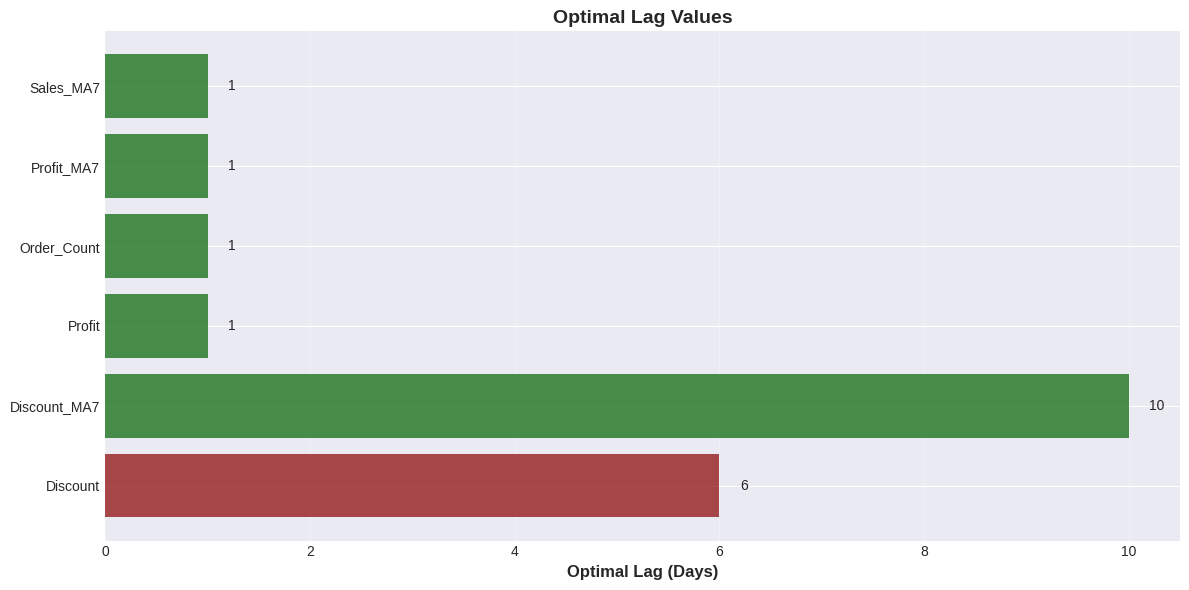

Green = Selected | Red = Not Selected


In [54]:
# Optimal lag bar chart
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['darkgreen' if x == 'Yes' else 'darkred' for x in results_df['Selected']]
ax.barh(results_df['Feature'], results_df['Best_Lag'], color=colors, alpha=0.7)

ax.set_xlabel('Optimal Lag (Days)', fontsize=12, fontweight='bold')
ax.set_title('Optimal Lag Values', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

for i, row in enumerate(results_df.itertuples()):
    ax.text(row.Best_Lag + 0.2, i, f"{row.Best_Lag}", va='center')

plt.tight_layout()
plt.show()

print("Green = Selected | Red = Not Selected")

## 7. Combined Visualization

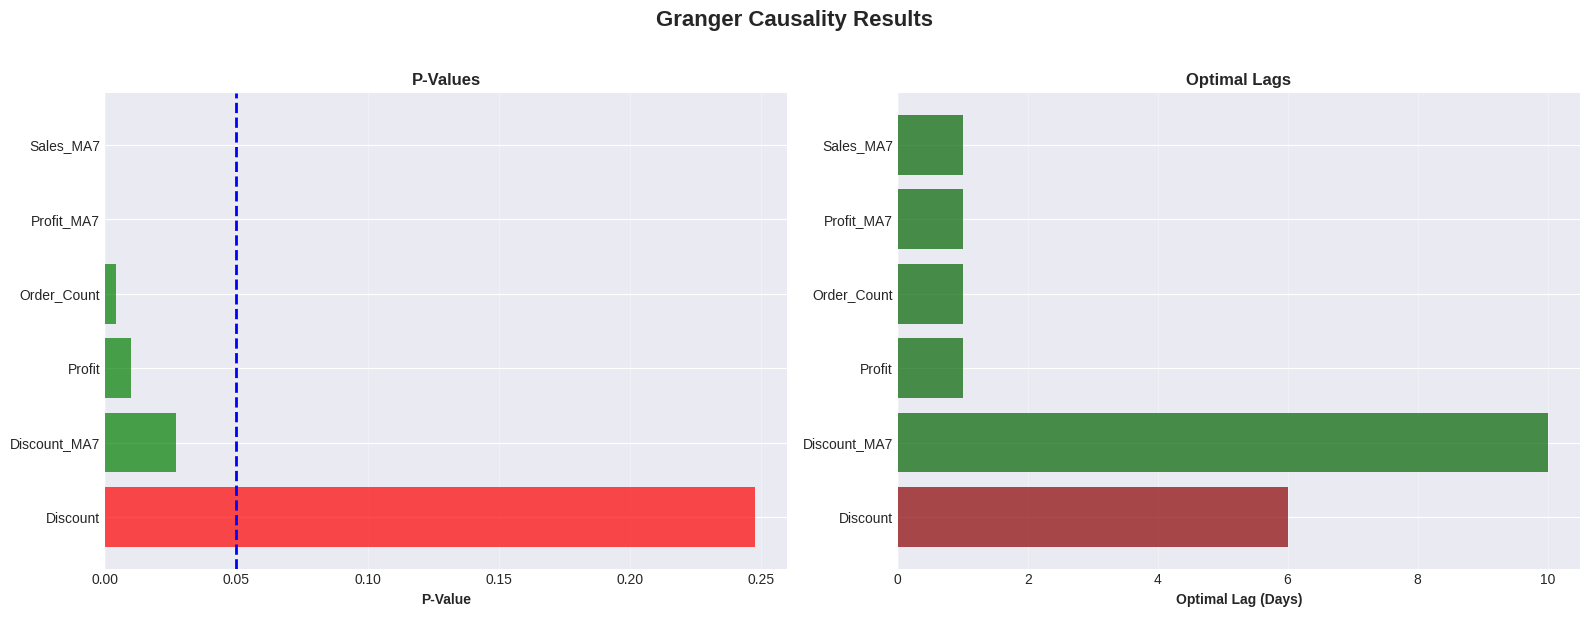

In [55]:
# Combined chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# P-values
colors1 = ['green' if x == 'Yes' else 'red' for x in results_df['Selected']]
axes[0].barh(results_df['Feature'], results_df['P_Value'], color=colors1, alpha=0.7)
axes[0].axvline(0.05, color='blue', linestyle='--', linewidth=2)
axes[0].set_xlabel('P-Value', fontweight='bold')
axes[0].set_title('P-Values', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Lags
colors2 = ['darkgreen' if x == 'Yes' else 'darkred' for x in results_df['Selected']]
axes[1].barh(results_df['Feature'], results_df['Best_Lag'], color=colors2, alpha=0.7)
axes[1].set_xlabel('Optimal Lag (Days)', fontweight='bold')
axes[1].set_title('Optimal Lags', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.suptitle('Granger Causality Results', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Feature Importance

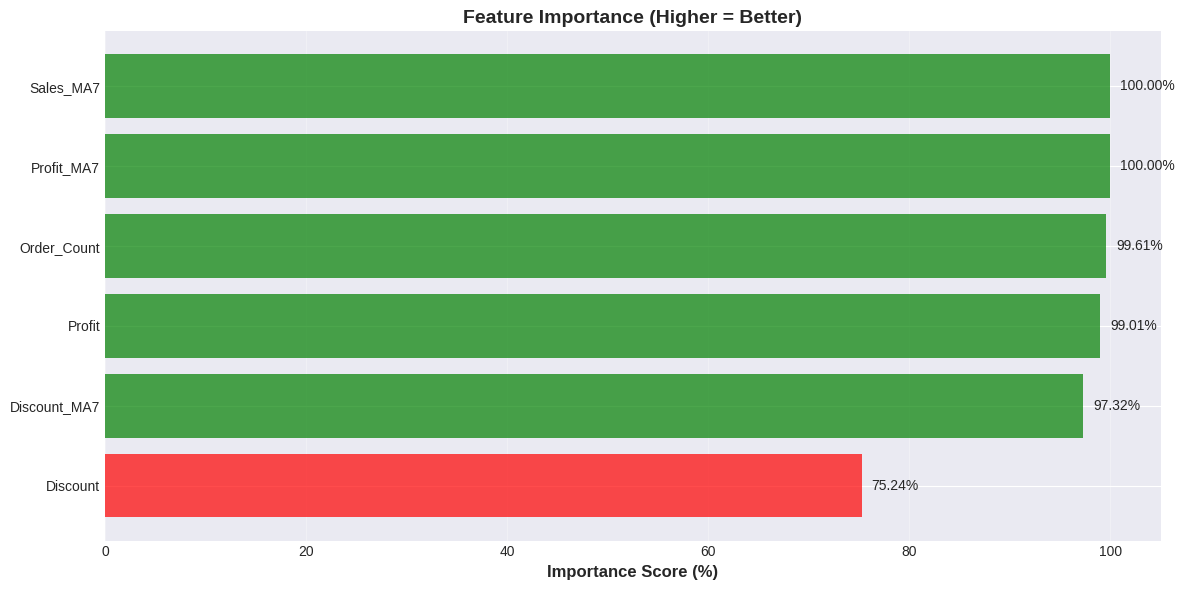

In [56]:
# Calculate importance
results_df['Importance'] = (1 - results_df['P_Value']) * 100

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['green' if x == 'Yes' else 'red' for x in results_df['Selected']]
ax.barh(results_df['Feature'], results_df['Importance'], color=colors, alpha=0.7)

ax.set_xlabel('Importance Score (%)', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance (Higher = Better)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

for i, row in enumerate(results_df.itertuples()):
    ax.text(row.Importance + 1, i, f"{row.Importance:.2f}%", va='center')

plt.tight_layout()
plt.show()

## 9. Export Results

In [57]:
# Save results
results_df.to_csv('granger_causality_results.csv', index=False)
print("✓ Saved to 'granger_causality_results.csv'")

# Save selected features
selected_list = results_df[results_df['Selected'] == 'Yes']['Feature'].tolist()
with open('selected_features.txt', 'w') as f:
    f.write("Selected Features\n" + "="*50 + "\n")
    for feat in selected_list:
        f.write(f"{feat}\n")

print("✓ Saved to 'selected_features.txt'")

# Summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Total Features Tested: {len(results_df)}")
print(f"Features Selected: {len(selected_list)}")
print(f"Selected: {', '.join(selected_list) if selected_list else 'None'}")
print("="*60)

✓ Saved to 'granger_causality_results.csv'
✓ Saved to 'selected_features.txt'

SUMMARY
Total Features Tested: 6
Features Selected: 5
Selected: Sales_MA7, Profit_MA7, Order_Count, Profit, Discount_MA7


## 10. Product-Level Feature Extraction

In [58]:
# Prepare product-level data
product_data = df.groupby(['Order Date', 'Category']).agg({
    'Sales': 'sum',
    'Profit': 'sum',
    'Discount': 'mean',
    'Order ID': 'count'
}).reset_index()

product_data.rename(columns={'Order ID': 'Order_Count'}, inplace=True)

# Pivot to get each category as a column
product_pivot = product_data.pivot_table(
    index='Order Date',
    columns='Category',
    values='Sales',
    aggfunc='sum',
    fill_value=0
)

# Resample and fill missing dates
product_pivot = product_pivot.resample('D').asfreq().fillna(0)

# Apply differencing for stationarity
product_diff = product_pivot.diff().dropna()

print(f"Product data shape: {product_diff.shape}")
print(f"Categories: {product_pivot.columns.tolist()}")
product_diff.head()

Product data shape: (1438, 7)
Categories: [0, 1, 2, 3, 4, 5, 6]


Category,0,1,2,3,4,5,6
Order Date,,,,,,,
2015-01-04,0.5845,0.0990,0.0000,0.0000,0.0000,0.0000,0.1295
2015-01-05,-0.7665,-0.0990,0.1890,0.0000,0.0000,0.0000,-0.1295
2015-01-06,0.0000,0.5185,0.7095,0.3715,0.8505,1.3340,1.8280
2015-01-07,0.3900,-0.5185,-0.1805,-0.3715,-0.8505,-1.3340,-1.8280
2015-01-08,-0.3900,0.0000,-0.7180,0.0000,0.0000,0.0000,0.0000


In [59]:
# Map category codes to names
category_map = {
    0: 'Beverages',
    1: 'Breakfast',
    2: 'Dairy',
    3: 'Eggs',
    4: 'Fruits',
    5: 'Meat',
    6: 'Vegetables'
}

# Rename columns to category names
product_diff.columns = [category_map.get(col, f'Category_{col}') for col in product_diff.columns]

print("Product categories:")
print(product_diff.columns.tolist())

Product categories:
['Beverages', 'Breakfast', 'Dairy', 'Eggs', 'Fruits', 'Meat', 'Vegetables']


## 11. Test Product Categories

In [60]:
# Calculate total sales per category
total_sales_by_category = df.groupby('Category')['Sales'].sum().sort_values(ascending=False)
total_sales_by_category.index = [category_map.get(idx, f'Category_{idx}') for idx in total_sales_by_category.index]

# Select target category (highest sales)
target_category = total_sales_by_category.index[0]
other_categories = [col for col in product_diff.columns if col != target_category]

print(f"Target Category: {target_category}")
print(f"\nTesting which categories Granger-cause {target_category}...")

# Test each category
product_results = []
for category in other_categories:
    result = test_granger_causality(product_diff, target_category, category, max_lag=7)
    if result:
        product_results.append(result)

print(f"\n✓ Tested {len(product_results)} product categories")

Target Category: Dairy

Testing which categories Granger-cause Dairy...

✓ Tested 6 product categories

✓ Tested 6 product categories


## 12. Product Results Table

In [61]:
# Create product results table
product_results_df = pd.DataFrame(product_results).sort_values('P_Value')

print("\n" + "="*60)
print(f"PRODUCT CATEGORIES GRANGER-CAUSING {target_category}")
print("="*60)
print(product_results_df.to_string(index=False))

selected_products = product_results_df[product_results_df['Selected'] == 'Yes']
print(f"\n✓ Selected Categories: {len(selected_products)} out of {len(product_results_df)}")

product_results_df


PRODUCT CATEGORIES GRANGER-CAUSING Dairy
   Feature  P_Value  Best_Lag Selected
    Fruits   0.0000         7      Yes
 Breakfast   0.0005         7      Yes
      Eggs   0.0006         7      Yes
 Beverages   0.0311         7      Yes
Vegetables   0.1005         4       No
      Meat   0.2679         7       No

✓ Selected Categories: 4 out of 6


,Feature,P_Value,Best_Lag,Selected
3,Fruits,0.0000,7,Yes
1,Breakfast,0.0005,7,Yes
2,Eggs,0.0006,7,Yes
0,Beverages,0.0311,7,Yes
5,Vegetables,0.1005,4,No
4,Meat,0.2679,7,No


## 13. Product P-Values Visualization

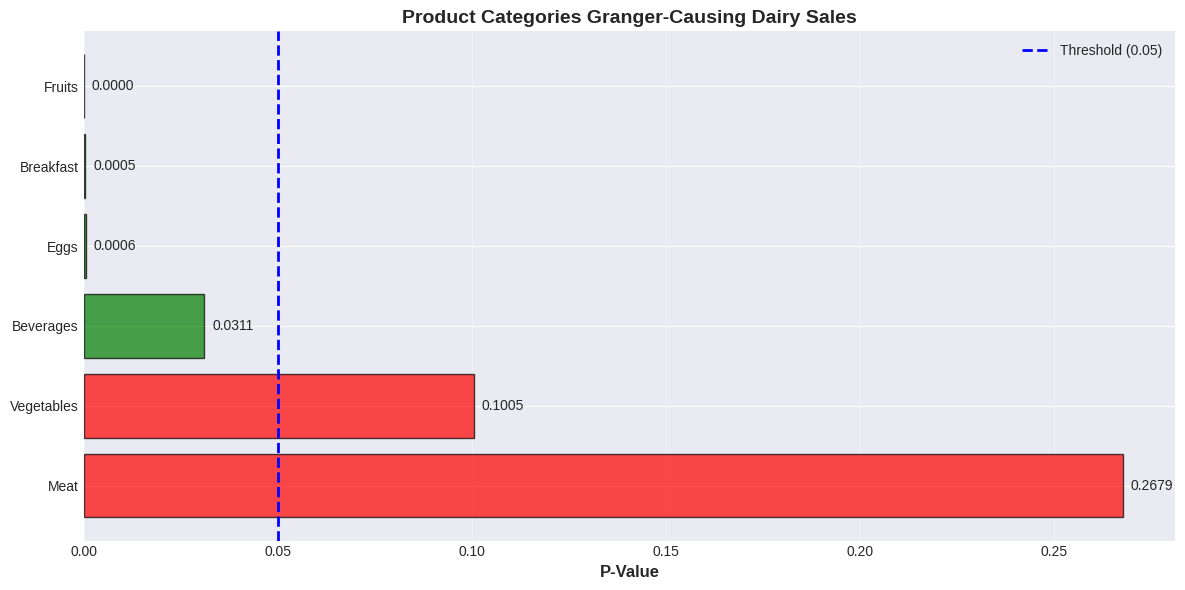

Green = Selected | Red = Not Selected


In [62]:
# Product P-Values bar chart
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['green' if x == 'Yes' else 'red' for x in product_results_df['Selected']]
ax.barh(product_results_df['Feature'], product_results_df['P_Value'], color=colors, alpha=0.7, edgecolor='black')
ax.axvline(0.05, color='blue', linestyle='--', linewidth=2, label='Threshold (0.05)')

ax.set_xlabel('P-Value', fontsize=12, fontweight='bold')
ax.set_title(f'Product Categories Granger-Causing {target_category} Sales', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

for i, row in enumerate(product_results_df.itertuples()):
    ax.text(row.P_Value + 0.002, i, f"{row.P_Value:.4f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("Green = Selected | Red = Not Selected")

## 14. Product Sales Distribution

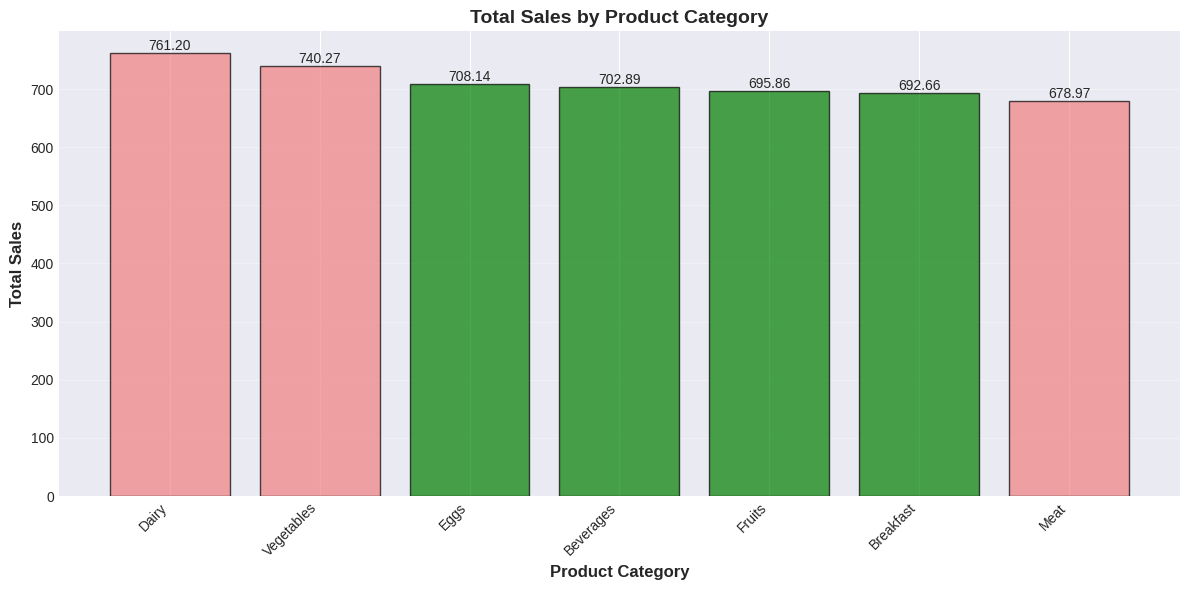

Green = Granger-causes Dairy | Red = Does not Granger-cause


In [63]:
# Total sales by category
fig, ax = plt.subplots(figsize=(12, 6))

colors_sales = ['green' if cat in selected_products['Feature'].values else 'lightcoral' 
                for cat in total_sales_by_category.index]
bars = ax.bar(total_sales_by_category.index, total_sales_by_category.values, 
              color=colors_sales, alpha=0.7, edgecolor='black')

ax.set_xlabel('Product Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Sales', fontsize=12, fontweight='bold')
ax.set_title('Total Sales by Product Category', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Green = Granger-causes {target_category} | Red = Does not Granger-cause")

## 15. Product Combined Visualization

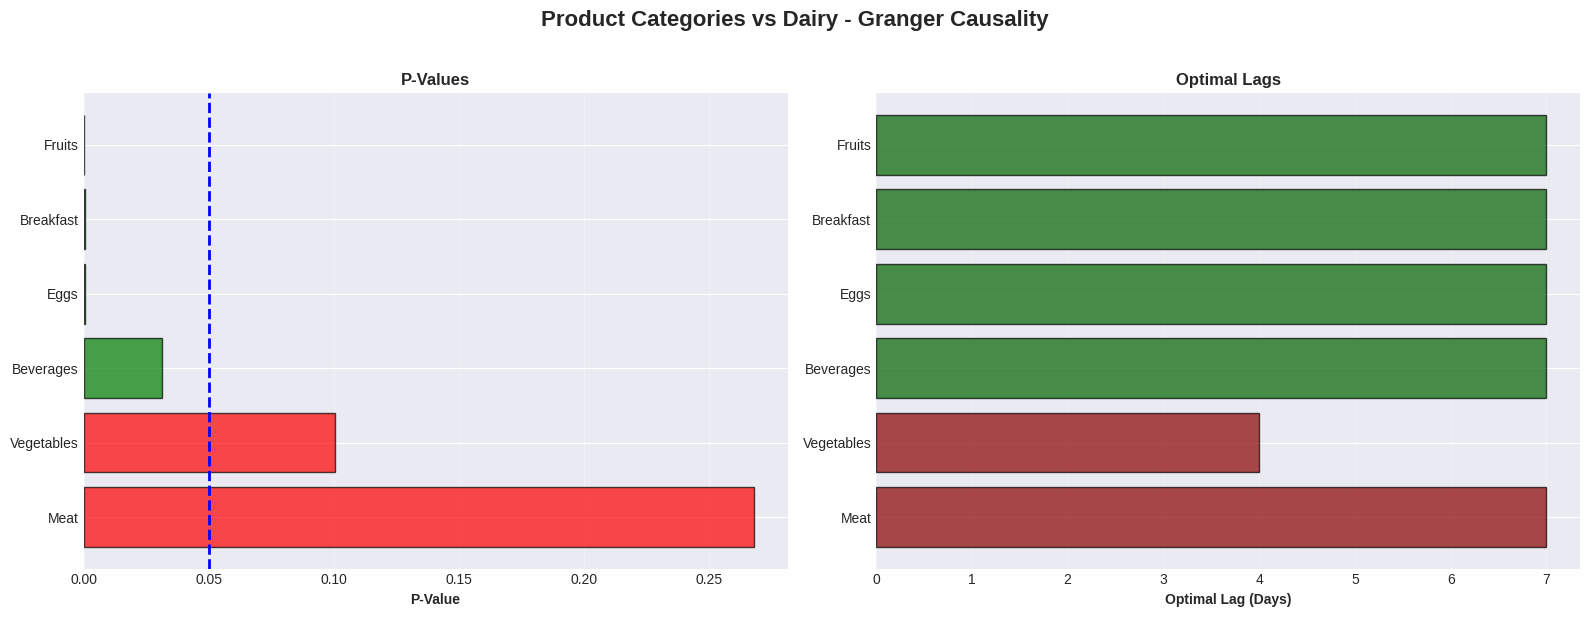

In [64]:
# Combined product visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# P-values
colors1 = ['green' if x == 'Yes' else 'red' for x in product_results_df['Selected']]
axes[0].barh(product_results_df['Feature'], product_results_df['P_Value'], 
             color=colors1, alpha=0.7, edgecolor='black')
axes[0].axvline(0.05, color='blue', linestyle='--', linewidth=2)
axes[0].set_xlabel('P-Value', fontweight='bold')
axes[0].set_title('P-Values', fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Lags
colors2 = ['darkgreen' if x == 'Yes' else 'darkred' for x in product_results_df['Selected']]
axes[1].barh(product_results_df['Feature'], product_results_df['Best_Lag'], 
             color=colors2, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Optimal Lag (Days)', fontweight='bold')
axes[1].set_title('Optimal Lags', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.suptitle(f'Product Categories vs {target_category} - Granger Causality', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 16. Product Importance Score

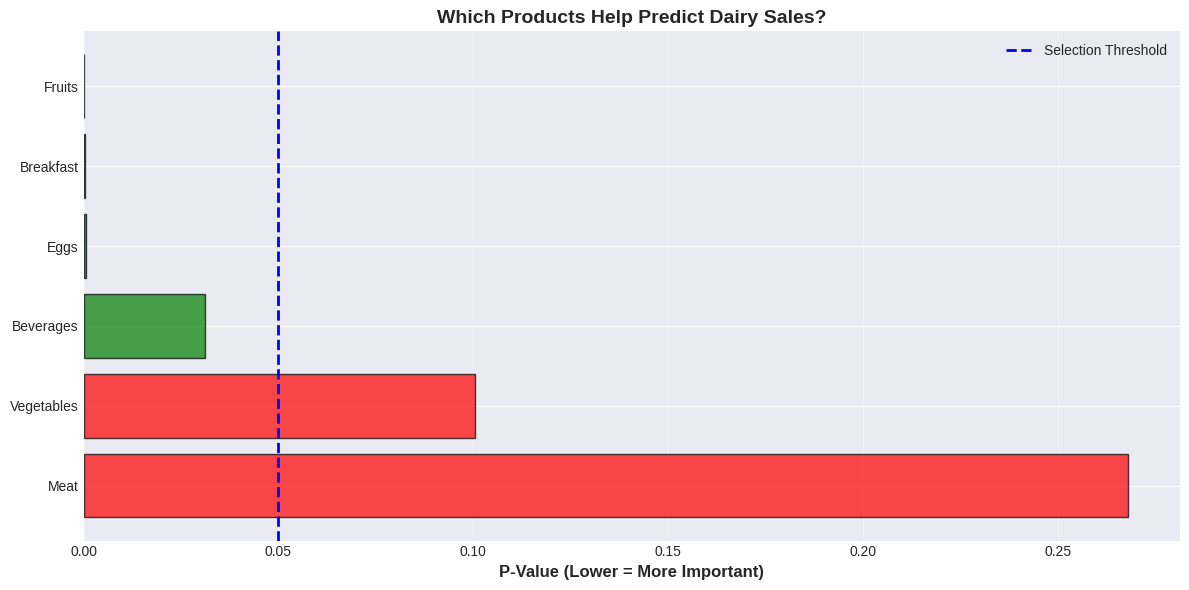


Green = Important for prediction | Red = Not important


In [65]:
# Simple product importance visualization
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['green' if x == 'Yes' else 'red' for x in product_results_df['Selected']]
ax.barh(product_results_df['Feature'], product_results_df['P_Value'], 
        color=colors, alpha=0.7, edgecolor='black')

ax.set_xlabel('P-Value (Lower = More Important)', fontsize=12, fontweight='bold')
ax.set_title(f'Which Products Help Predict {target_category} Sales?', 
             fontsize=14, fontweight='bold')
ax.axvline(0.05, color='blue', linestyle='--', linewidth=2, label='Selection Threshold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

print("\nGreen = Important for prediction | Red = Not important")

## 17. Sales Trends and Future Growth Analysis

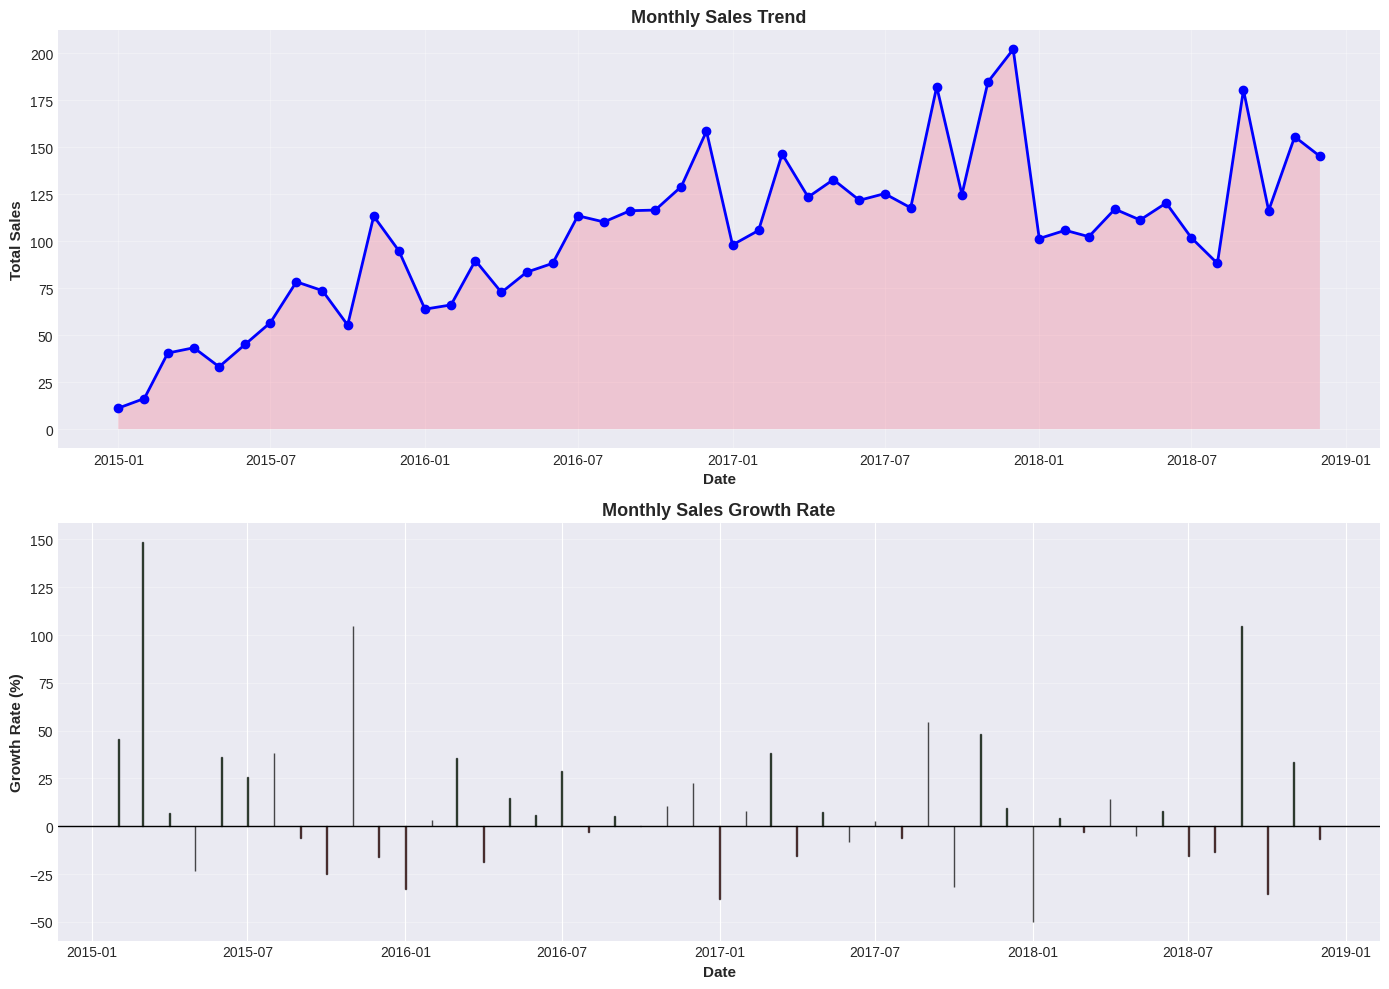


Average Monthly Growth: 10.94%
Maximum Growth: 148.74%
Minimum Growth: -49.82%


In [66]:
# Calculate monthly growth trends
df['Year_Month'] = df['Order Date'].dt.to_period('M')
monthly_sales = df.groupby('Year_Month')['Sales'].sum()
monthly_sales.index = monthly_sales.index.to_timestamp()

# Calculate growth rate
monthly_growth = monthly_sales.pct_change() * 100

# Plot sales trend
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Sales trend
axes[0].plot(monthly_sales.index, monthly_sales.values, marker='o', linewidth=2, markersize=6, color='blue')
axes[0].fill_between(monthly_sales.index, monthly_sales.values, alpha=0.3)
axes[0].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Total Sales', fontsize=11, fontweight='bold')
axes[0].set_title('Monthly Sales Trend', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Growth rate
colors_growth = ['green' if x > 0 else 'red' for x in monthly_growth]
axes[1].bar(monthly_growth.index, monthly_growth.values, color=colors_growth, alpha=0.7, edgecolor='black')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Growth Rate (%)', fontsize=11, fontweight='bold')
axes[1].set_title('Monthly Sales Growth Rate', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nAverage Monthly Growth: {monthly_growth.mean():.2f}%")
print(f"Maximum Growth: {monthly_growth.max():.2f}%")
print(f"Minimum Growth: {monthly_growth.min():.2f}%")

## 18. Product Category Growth Trends

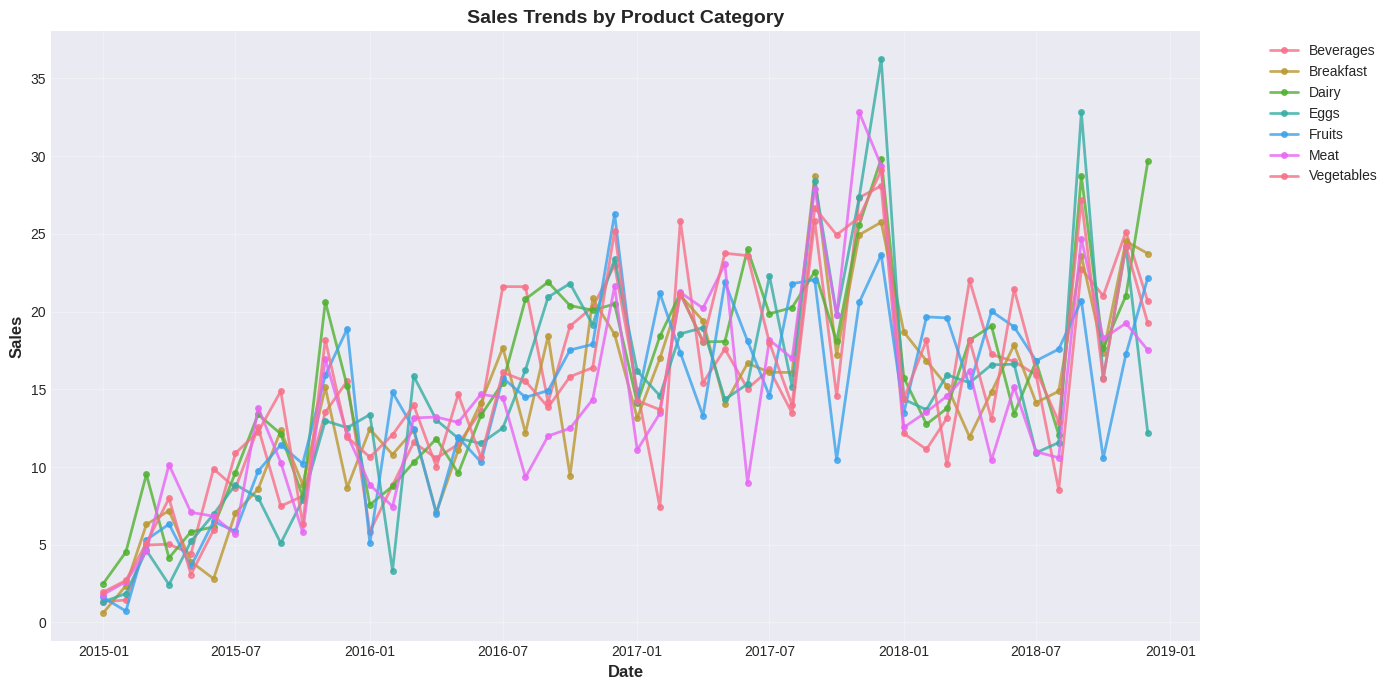


This shows which product categories are growing over time


In [67]:
# Monthly sales by category
df['Category_Name'] = df['Category'].map(category_map)
category_monthly = df.groupby(['Year_Month', 'Category_Name'])['Sales'].sum().unstack(fill_value=0)
category_monthly.index = category_monthly.index.to_timestamp()

# Plot category trends
fig, ax = plt.subplots(figsize=(14, 7))

for category in category_monthly.columns:
    ax.plot(category_monthly.index, category_monthly[category], marker='o', 
            linewidth=2, markersize=4, label=category, alpha=0.8)

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Sales', fontsize=12, fontweight='bold')
ax.set_title('Sales Trends by Product Category', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nThis shows which product categories are growing over time")

## 19. Growth Rate by Product Category

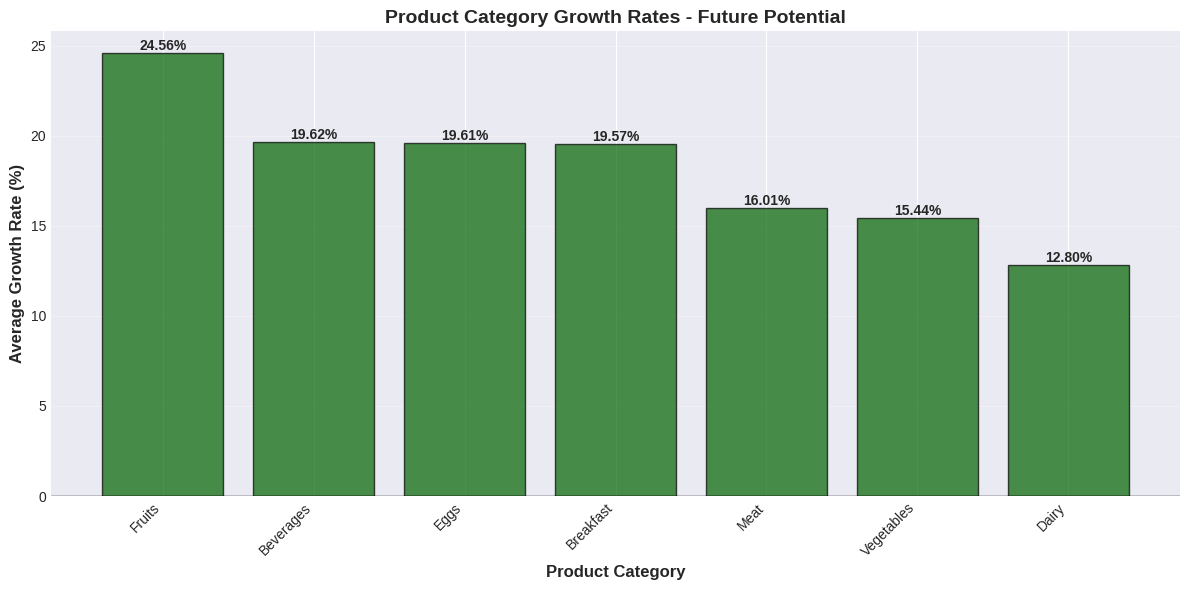


GROWTH ANALYSIS
  Category  Avg_Growth_Rate_%
    Fruits            24.5646
 Beverages            19.6248
      Eggs            19.6075
 Breakfast            19.5663
      Meat            16.0056
Vegetables            15.4352
     Dairy            12.8012

Green = Growing | Red = Declining


In [68]:
# Calculate average growth rate per category
category_growth = {}
for category in category_monthly.columns:
    growth_rate = category_monthly[category].pct_change().mean() * 100
    category_growth[category] = growth_rate

growth_df = pd.DataFrame(list(category_growth.items()), columns=['Category', 'Avg_Growth_Rate_%'])
growth_df = growth_df.sort_values('Avg_Growth_Rate_%', ascending=False)

# Visualize growth rates
fig, ax = plt.subplots(figsize=(12, 6))

colors_cat = ['darkgreen' if x > 0 else 'darkred' for x in growth_df['Avg_Growth_Rate_%']]
bars = ax.bar(growth_df['Category'], growth_df['Avg_Growth_Rate_%'], 
              color=colors_cat, alpha=0.7, edgecolor='black')

ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Product Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Growth Rate (%)', fontsize=12, fontweight='bold')
ax.set_title('Product Category Growth Rates - Future Potential', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}%',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("GROWTH ANALYSIS")
print("="*60)
print(growth_df.to_string(index=False))
print("\nGreen = Growing | Red = Declining")

## 20. Future Needs and Recommendations

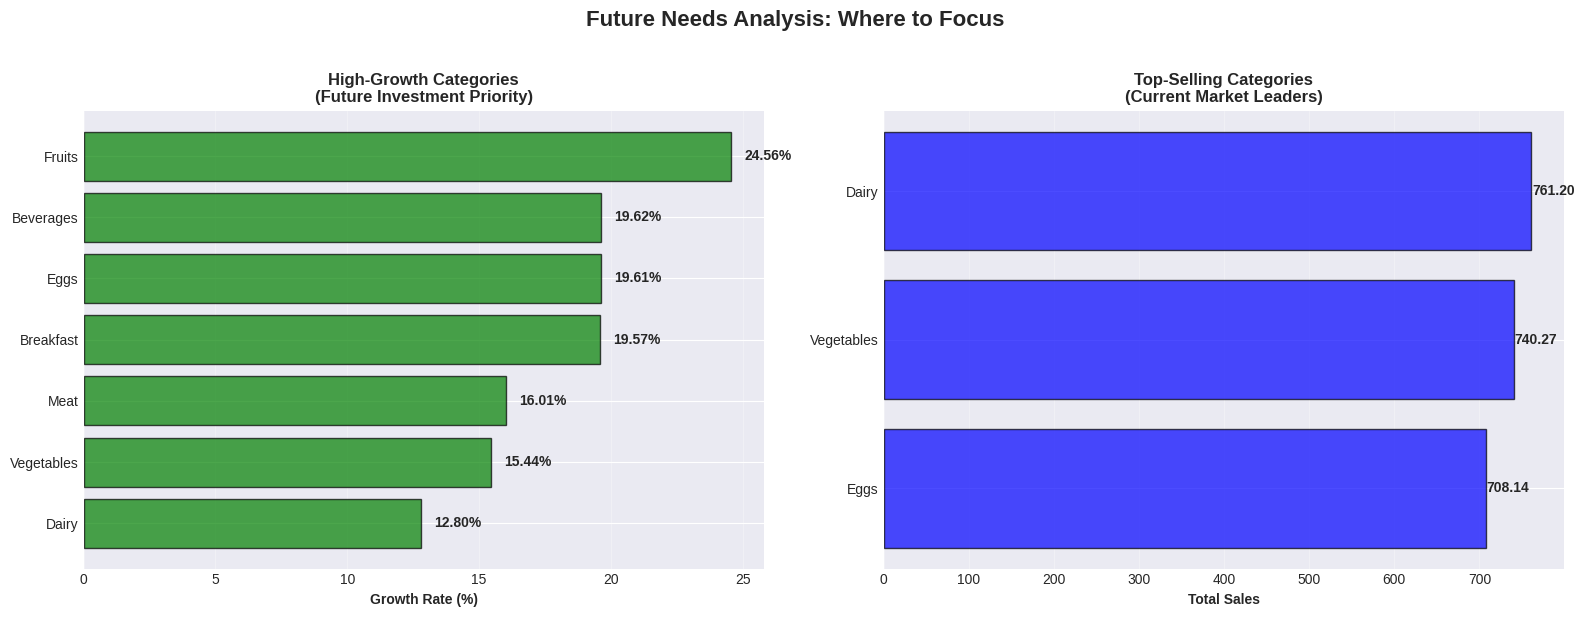


FUTURE NEEDS AND RECOMMENDATIONS

📈 HIGH-GROWTH CATEGORIES (Focus for Future):
  • Fruits: 24.56% growth
  • Beverages: 19.62% growth
  • Eggs: 19.61% growth

💰 TOP-SELLING CATEGORIES (Current Revenue Drivers):
  • Dairy: 761.20 total sales
  • Vegetables: 740.27 total sales
  • Eggs: 708.14 total sales

🎯 STRATEGIC RECOMMENDATIONS:
  1. Invest in high-growth categories for future expansion
  2. Maintain strong inventory for top-selling categories
  3. Monitor declining categories for intervention
  4. Focus marketing on products with both high sales and growth


In [69]:
# Identify high-growth and high-sales categories
top_growing = growth_df[growth_df['Avg_Growth_Rate_%'] > 0].sort_values('Avg_Growth_Rate_%', ascending=False)
top_sales = total_sales_by_category.head(3)

# Create future needs visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# High-growth categories (Future potential)
if len(top_growing) > 0:
    axes[0].barh(top_growing['Category'], top_growing['Avg_Growth_Rate_%'], 
                 color='green', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Growth Rate (%)', fontweight='bold')
    axes[0].set_title('High-Growth Categories\n(Future Investment Priority)', fontweight='bold', fontsize=12)
    axes[0].grid(True, alpha=0.3, axis='x')
    axes[0].invert_yaxis()
    
    for i, row in enumerate(top_growing.itertuples()):
        axes[0].text(row._2 + 0.5, i, f"{row._2:.2f}%", va='center', fontweight='bold')

# Top sales categories (Current strength)
axes[1].barh(top_sales.index, top_sales.values, color='blue', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Total Sales', fontweight='bold')
axes[1].set_title('Top-Selling Categories\n(Current Market Leaders)', fontweight='bold', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

for i, (idx, val) in enumerate(top_sales.items()):
    axes[1].text(val + 0.5, i, f"{val:.2f}", va='center', fontweight='bold')

plt.suptitle('Future Needs Analysis: Where to Focus', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Recommendations
print("\n" + "="*70)
print("FUTURE NEEDS AND RECOMMENDATIONS")
print("="*70)

print("\n📈 HIGH-GROWTH CATEGORIES (Focus for Future):")
if len(top_growing) > 0:
    for idx, row in top_growing.head(3).iterrows():
        print(f"  • {row['Category']}: {row['Avg_Growth_Rate_%']:.2f}% growth")
else:
    print("  No positive growth categories identified")

print("\n💰 TOP-SELLING CATEGORIES (Current Revenue Drivers):")
for idx, val in top_sales.items():
    print(f"  • {idx}: {val:.2f} total sales")

print("\n🎯 STRATEGIC RECOMMENDATIONS:")
print("  1. Invest in high-growth categories for future expansion")
print("  2. Maintain strong inventory for top-selling categories")
print("  3. Monitor declining categories for intervention")
print("  4. Focus marketing on products with both high sales and growth")
print("="*70)

## 21. Export All Results

In [70]:
# Save all results
results_df.to_csv('granger_feature_results.csv', index=False)
product_results_df.to_csv('granger_product_results.csv', index=False)
growth_df.to_csv('product_growth_analysis.csv', index=False)

print("✓ Saved to 'granger_feature_results.csv'")
print("✓ Saved to 'granger_product_results.csv'")
print("✓ Saved to 'product_growth_analysis.csv'")

# Save selected features
selected_list = results_df[results_df['Selected'] == 'Yes']['Feature'].tolist()
with open('selected_features.txt', 'w') as f:
    f.write("SELECTED FEATURES (Granger Causality)\n")
    f.write("="*60 + "\n\n")
    for feat in selected_list:
        f.write(f"{feat}\n")

# Save selected products
selected_product_list = product_results_df[product_results_df['Selected'] == 'Yes']['Feature'].tolist()
with open('selected_products.txt', 'w') as f:
    f.write(f"SELECTED PRODUCTS (Granger-cause {target_category})\n")
    f.write("="*60 + "\n\n")
    for prod in selected_product_list:
        f.write(f"{prod}\n")

print("✓ Saved to 'selected_features.txt'")
print("✓ Saved to 'selected_products.txt'")

# Final comprehensive summary
print("\n" + "="*70)
print("COMPLETE ANALYSIS SUMMARY")
print("="*70)

print("\n1. FEATURE EXTRACTION:")
print(f"   Total Features Tested: {len(results_df)}")
print(f"   Features Selected: {len(selected_list)}")
if selected_list:
    print(f"   Selected: {', '.join(selected_list)}")

print("\n2. PRODUCT ANALYSIS:")
print(f"   Total Categories Tested: {len(product_results_df)}")
print(f"   Categories Selected: {len(selected_product_list)}")
if selected_product_list:
    print(f"   Selected: {', '.join(selected_product_list)}")

print("\n3. GROWTH INSIGHTS:")
print(f"   Average Overall Growth: {monthly_growth.mean():.2f}%")
if len(top_growing) > 0:
    print(f"   Fastest Growing: {top_growing.iloc[0]['Category']} ({top_growing.iloc[0]['Avg_Growth_Rate_%']:.2f}%)")
print(f"   Best Seller: {top_sales.index[0]} ({top_sales.values[0]:.2f} sales)")

print("\n" + "="*70)
print("✅ FEATURE EXTRACTION AND GROWTH ANALYSIS COMPLETE!")
print("="*70)

✓ Saved to 'granger_feature_results.csv'
✓ Saved to 'granger_product_results.csv'
✓ Saved to 'product_growth_analysis.csv'
✓ Saved to 'selected_features.txt'
✓ Saved to 'selected_products.txt'

COMPLETE ANALYSIS SUMMARY

1. FEATURE EXTRACTION:
   Total Features Tested: 6
   Features Selected: 5
   Selected: Sales_MA7, Profit_MA7, Order_Count, Profit, Discount_MA7

2. PRODUCT ANALYSIS:
   Total Categories Tested: 6
   Categories Selected: 4
   Selected: Fruits, Breakfast, Eggs, Beverages

3. GROWTH INSIGHTS:
   Average Overall Growth: 10.94%
   Fastest Growing: Fruits (24.56%)
   Best Seller: Dairy (761.20 sales)

✅ FEATURE EXTRACTION AND GROWTH ANALYSIS COMPLETE!
